# Volume Weighted Average vs Simple Moving Average

We are developing a simple model to test if the volume weighted average price (VWAP) is a better indicator of future stock price than a simple moving average price (SMAP). Our hypothesis is that it is, since the VWAP contains more information (i.e. the volume of stocks traded) than the SMAP. Before developing the model, we first give some definitions.

For our purposes, we define the VWAP of stock $A$ as
$$\mathrm{VWAP}_{A}(d) = \frac{\sum_{t=-d}^{0} p_{A}(t)\times V_{A}(t)}{\sum_{t=-d}^{0} V_{A}(t)}$$
Here $p_{A}(d)$ and $V_{A}(d)$ are the closing price of stock $A$ and the volume of stock $A$ (number of shares) , respectively, traded $d$ market days ago. The variable $d$ thus serves as the anchoring point for the volume weighted average.

The SMAP of stock $A$ is defined as
$$\mathrm{SMAP}_{A}(d) = \frac{1}{d+1}\sum_{t=-d}^{0} p_{A}(t)$$
where $d$ is again the lookback period.

To test the model, we will analyze the stocks that constitute the MMI. Our data came from [kaggle](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs).

In [1]:
# Lets first import some useful libraries for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates  as dates

# Create a dictionary of stock ticker symbols
ARCAMMI_Stocks={'AmericanExpress':'axp',
                'Boeing':'ba',
                'Chevron':'cvx',
                'DowDupont':'dwdp',
                'Disney':'dis',
                'GeneralElectric':'ge',
                'HewlettPackard':'hpq',
                'IBM':'ibm',
                'JohnsonAndJohnson':'jnj',
                'JPMorgan':'jpm',
                'CocaCola':'ko',
                'McDonalds':'mcd',
                '3M':'mmm',
                'Merck':'mrk',
                'Microsoft':'msft',
                'ProcterAndGamble':'pg',
                'WellsFargo':'wfc',
                'Walmart':'wmt',
                'ExxonMobil':'xom'}

class vwap_strategy():
    """Class to test vwap strategy"""

    def __init__(self, stocks, lookback=5):
        """Reading in stock data, calculate VWAP an SMAP, 
        and the value of the portfolio trading with this strategy"""

        # Initialize class data
        self.data     = {}
        self.stocks   = stocks
        self.lookback = lookback
        
        # read in data and perform initial VWAP and SMAP calculations
        self.read_data_all()
        self.get_vwap_all()
        self.get_smap_all()
        self.set_signal_all()
        self.set_value_all()

    def add_stock(self, company,ticker):
        self.stocks[company] = ticker
        self.read_data(company,ticker)
        self.get_vwap(company)
        self.get_smap(company)
        self.set_signal(company)
        self.set_value(company)
        
        
    # <<< --------------------------------------------------------- >>> #
    def read_data_all(self):
        for company, ticker in self.stocks.iteritems():
            self.read_data(company,ticker)
            
    def get_vwap_all(self):
        """Calculate the VWAP for all available companies"""
        for company in self.data:
            self.get_vwap(company)
            
    def get_smap_all(self):
        """Calculate the SMAP for all available companies"""
        for company in self.data:
            self.get_smap(company)
            
    def set_signal_all(self):
        for company in self.data:
            self.set_signal(company)

    def set_value_all(self):
        for company in self.data:
            self.set_value(company)
    # <<< --------------------------------------------------------- >>> #
            
            
            
    # <<< --------------------------------------------------------- >>> #
    def read_data(self,company,ticker):
        """Read in stock data of a given company"""
        self.data[company] = pd.read_csv('MMI_DATA/'+ticker+'.us.txt',index_col=0,
                                        usecols=['Date','Open','Close','Volume'])
            
    def get_vwap(self, company):
        """Calculate the VWAP for a company using lookback days as an anchor point"""
        n = self.data[company].shape[0]
        vwap = np.zeros(n)
            
        for i in range(self.lookback,n):
            lb = i - self.lookback #lower bound
            ub = i + 1 #upper bound
            vwap[i]  = np.multiply( self.data[company]['Close'].iloc[lb:ub], 
                                    self.data[company]['Volume'].iloc[lb:ub]).sum()
            vwap[i] /= np.sum(1.*self.data[company]['Volume'].iloc[lb:ub])
        
        self.data[company]['VWAP'] = vwap

    def get_smap(self, company):
        """Calculate the SMAP for a company using lookback days as an anchor point"""
        n = self.data[company].shape[0]
        smap = np.zeros(n)
            
        for i in range(self.lookback,n):
            lb = i - self.lookback
            ub = i + 1
            smap[i] = np.mean(self.data[company]['Close'].iloc[lb:ub])
            
        self.data[company]['SMAP'] = smap

    # if the price is greater than VWAP or SMAP, we want to go long (1), otherwise we want to be in a cash position (0)
    def set_signal(self,company):
        n = self.data[company].shape[0]
        signal = np.zeros(n)
        
        for i in range(n):
            if self.data[company]['Close'].iloc[i] > self.data[company]['VWAP'].iloc[i] and i >= self.lookback:
                signal[i] = 1
            
        self.data[company]['VWAP_Signal'] = signal
            
            
        signal = np.zeros(n)
        for i in range(n):
            if self.data[company]['Close'].iloc[i] > self.data[company]['SMAP'].iloc[i] and i >= self.lookback:
                signal[i] = 1
                    
        self.data[company]['SMAP_Signal'] = signal
            
    def set_value(self, company):
        n = self.data[company].shape[0]
            
        value = np.zeros(n)
        value[0] = 1.
        for i in range(1,n):
            delta = ( self.data[company]['Open'].iloc[i] - self.data[company]['Open'].iloc[i-1])/(self.data[company]['Open'].iloc[i-1])
            value[i] = value[i-1]*(1 + self.data[company]['VWAP_Signal'].iloc[i-1]*delta)

        self.data[company]['VWAP_Value'] = value
         
        value = np.zeros(n)
        value[0] = 1.
        for i in range(1,n):
            delta = ( self.data[company]['Open'].iloc[i] - self.data[company]['Open'].iloc[i-1])/(self.data[company]['Open'].iloc[i-1])
            value[i] = value[i-1]*(1 + self.data[company]['SMAP_Signal'].iloc[i-1]*delta)

        self.data[company]['SMAP_Value'] = value
    # <<< --------------------------------------------------------- >>> #   
    
    
    # some convience functions
    def get_return_between(self,company,start,end,metric):
        # get percent return between two dates
        if metric != 'VWAP' and metric != 'SMAP':
            print "Metric {} unknown".format(metric)
            return 0
        
        ret = self.data[company].loc[end][metric+'_Value'] / self.data[company].loc[start][metric+'_Value']
            
        return ret*100 - 100

In [2]:
strategy = vwap_strategy( ARCAMMI_Stocks, lookback=15 )



Historical Closing Price for Disney Stock:


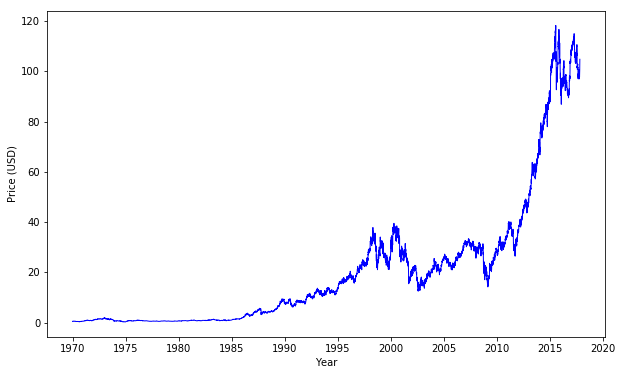

In [3]:
# Lets take a look at the disney data
print '\n\nHistorical Closing Price for Disney Stock:'
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot_date(strategy.data['Disney'].index.values, strategy.data['Disney']['Close'],
             color='blue',linewidth=1,marker='',linestyle='-')
ax.xaxis.set_major_locator(dates.YearLocator(base=5))
ax.set_xlabel('Year')
ax.set_ylabel('Price (USD)')
plt.show()
plt.close()



Historical Closing Price for Disney Stock Since 2015 with VWAP(15) and SWAP(15):


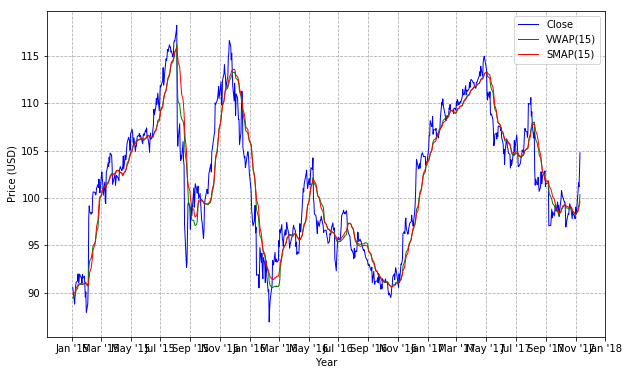

In [5]:
# Lets go ahead and take a look at the disney data from 2015 on along with the VWAP and SMAP values
print '\n\nHistorical Closing Price for Disney Stock Since 2015 with VWAP({}) and SWAP({}):'.format(strategy.lookback,strategy.lookback)
start = '2015-01-01'
fig, ax2 = plt.subplots(1,1,figsize=(10,6))

ax2.plot_date(strategy.data['Disney'][start:].index.values, strategy.data['Disney'][start::]['Close'],
             color='blue',linewidth=1,marker='',linestyle='-',label='Close')
ax2.plot_date(strategy.data['Disney'][start:].index.values, strategy.data['Disney'][start::]['VWAP'],
             color='green',linewidth=1,marker='',linestyle='-',label='VWAP('+str(strategy.lookback)+')')
ax2.plot_date(strategy.data['Disney'][start:].index.values, strategy.data['Disney'][start::]['SMAP'],
             color='red',linewidth=1,marker='',linestyle='-',label='SMAP('+str(strategy.lookback)+')')

ax2.xaxis.set_major_locator(dates.MonthLocator(interval=2))
ax2.xaxis.set_major_formatter(dates.DateFormatter("%b '%y"))
ax2.set_xlabel('Year')
ax2.set_ylabel('Price (USD)')
ax2.legend()
ax2.grid(linestyle='dashed')
plt.show()
plt.close()